In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [12]:
IMGSZ = 256
B_SIZE = 32
CHANNEL_SIZE = 3
EPOCHS = 25

In [13]:
datasets = tf.keras.preprocessing.image_dataset_from_directory(
    "RICE DATASETS",
    image_size=(IMGSZ,IMGSZ),
    shuffle=True,
    batch_size=B_SIZE
)

Found 5932 files belonging to 4 classes.


In [14]:
CLASS_NAMES = datasets.class_names
CLASS_NAMES

['Rice___bacterial_blight',
 'Rice___blast',
 'Rice___brown_spot',
 'Rice___tungro']

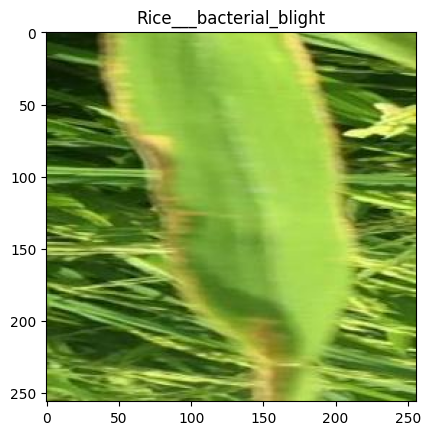

In [15]:
for image_batch, label_batch in datasets.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(CLASS_NAMES[label_batch[0]])

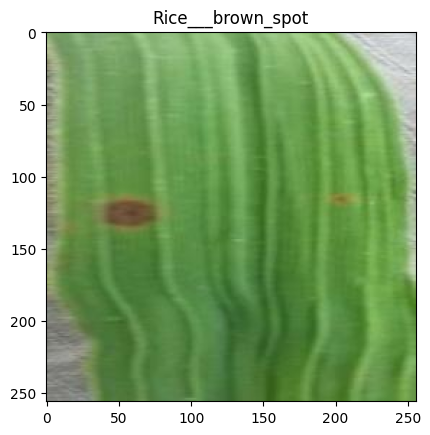

In [16]:
for image_batch, label_batch in datasets.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(CLASS_NAMES[label_batch[0]])

In [17]:
def get_train_test_eval_dataset(datasets, train_size=0.8, val_size=0.1, test_size=0.1, shuffle=True, shuffle_size=10000):
    assert (train_size + test_size + val_size) == 1
    
    ds_size = len(datasets)
    
    if shuffle:
        datasets = datasets.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_size * ds_size)
    val_size = int(val_size * ds_size)
    
    train_dataset = datasets.take(train_size)    
    val_dataset = datasets.skip(train_size).take(val_size)
    test_dataset = datasets.skip(train_size).skip(val_size)
    
    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = get_train_test_eval_dataset(datasets)

print("LENGTH OF TRAIN DATASET : ",len(train_dataset))
print("LENGTH OF TEST DATASET : ",len(test_dataset))
print("LENGTH OF EVAL DATASET : ",len(val_dataset))

LENGTH OF TRAIN DATASET :  148
LENGTH OF TEST DATASET :  20
LENGTH OF EVAL DATASET :  18


In [18]:
train_dataset = train_dataset.cache().shuffle(1000)
test_dataset = test_dataset.cache().shuffle(1000)
val_dataset = val_dataset.cache().shuffle(1000)

In [19]:
resize_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMGSZ,IMGSZ),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255),
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

model = tf.keras.Sequential([
    resize_rescale,
    data_augmentation,
    tf.keras.layers.Conv2D(32,(3,3),activation="relu",input_shape = (IMGSZ,IMGSZ,CHANNEL_SIZE)),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4,activation="softmax")

])

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
history_rec = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=B_SIZE,
    verbose=1,
    validation_data=val_dataset
)

Epoch 1/25
148/148 [==============================] - 239s 2s/step - loss: 1.1559 - accuracy: 0.4540 - val_loss: 0.9555 - val_accuracy: 0.6042
Epoch 2/25
148/148 [==============================] - 213s 1s/step - loss: 0.8892 - accuracy: 0.6467 - val_loss: 0.7120 - val_accuracy: 0.7205
Epoch 3/25
148/148 [==============================] - 213s 1s/step - loss: 0.7329 - accuracy: 0.7290 - val_loss: 0.5737 - val_accuracy: 0.7812
Epoch 4/25
148/148 [==============================] - 208s 1s/step - loss: 0.5656 - accuracy: 0.7890 - val_loss: 0.5521 - val_accuracy: 0.8073
Epoch 5/25
148/148 [==============================] - 225s 2s/step - loss: 0.4505 - accuracy: 0.8374 - val_loss: 0.2954 - val_accuracy: 0.8941
Epoch 6/25
148/148 [==============================] - 223s 2s/step - loss: 0.3337 - accuracy: 0.8764 - val_loss: 0.2470 - val_accuracy: 0.9010
Epoch 7/25
148/148 [==============================] - 216s 1s/step - loss: 0.2880 - accuracy: 0.8921 - val_loss: 0.1982 - val_accuracy: 0.9253

In [21]:
accuracy_pm = history_rec.history['accuracy']
loss_pm = history_rec.history['loss']
val_accuracy_pm = history_rec.history['val_accuracy']
val_loss_pm = history_rec.history['val_loss']

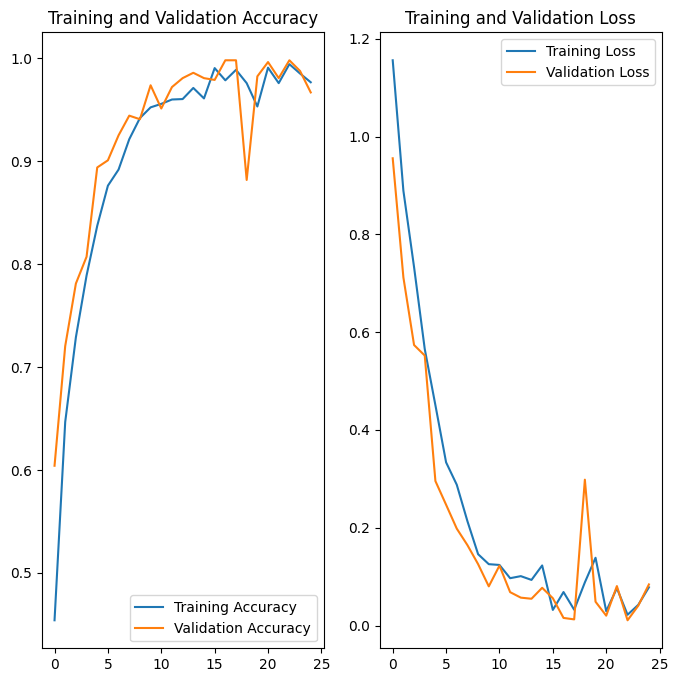

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy_pm, label='Training Accuracy')
plt.plot(range(EPOCHS), val_accuracy_pm, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss_pm, label='Training Loss')
plt.plot(range(EPOCHS), val_loss_pm, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
model.evaluate(test_dataset)

20/20 [==============================] - 14s 372ms/step - loss: 0.0774 - accuracy: 0.9766


[0.07742682099342346, 0.9765625]

1/1 [==============================] - 0s 33ms/step


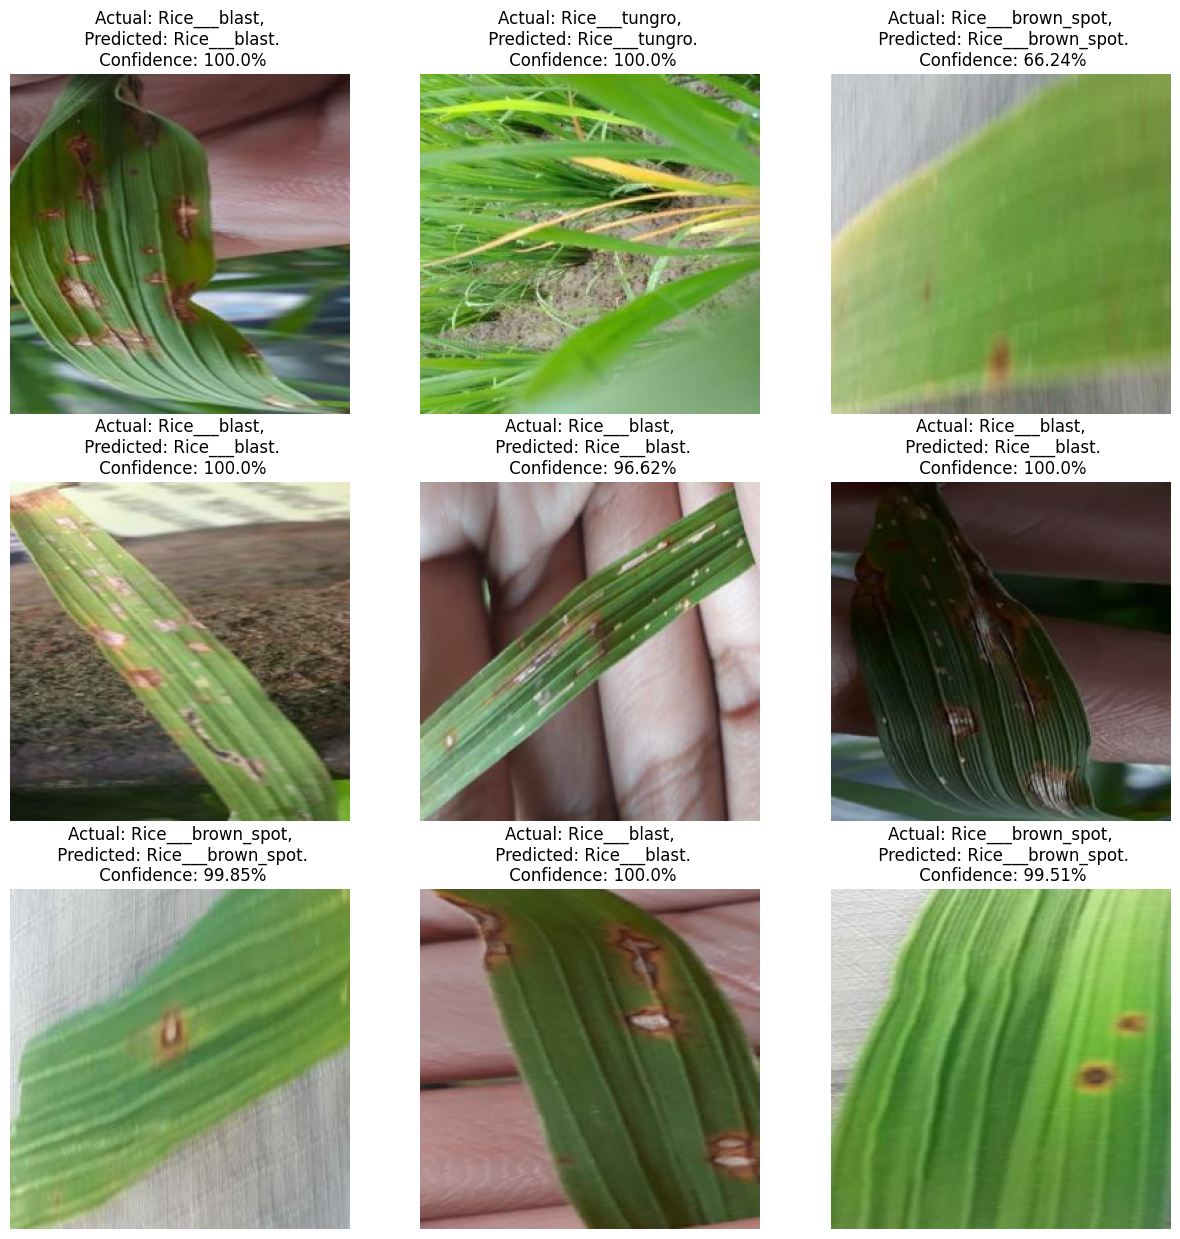

In [24]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        IMG = images[i].numpy()
        plt.imshow(IMG.astype("uint8"))

        img_array = tf.expand_dims(IMG, 0)
        predictions = model.predict(img_array)

        predicted_class = CLASS_NAMES[np.argmax(predictions[0])]
        confidence = round(100 * (np.max(predictions[0])), 2)
        actual_class = CLASS_NAMES[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [25]:
model_version = 5
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/5\assets


INFO:tensorflow:Assets written to: ./models/5\assets
